### Comparing the MC and Isaura energy

As a total, for the signal events, and the lost signal events

In [2]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'


sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
import core.functions as func
#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook


#%matplotlib widget
#import ipympl

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize

from tqdm import tqdm

# MACHINE LEARNING IMPORTS
import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


pd.set_option('display.max_rows', 500)

In [3]:
def collect_signal_events(folder_path, event_numbers):

    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]
    
    i = 0

    for file in tqdm(file_names):

        file_path = folder_path + file
        df = dstio.load_dst(file_path, 'DECO', 'Events')
        if (i == 0):
            signal_df = df[df['event'].isin(event_numbers)]
            i += 1
        else:
            signal_df = signal_df.append(df[df['event'].isin(event_numbers)], ignore_index = True)
        
    return signal_df
            

def collect_signal_events_MC(folder_path, event_numbers):

    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]
    
    i = 0

    for file in tqdm(file_names):

        file_path = folder_path + file
        df = mcio.load_mchits_df(file_path).reset_index()
        if (i == 0):
            signal_df = df[df['event_id'].isin(event_numbers)]
            i += 1
        else:
            signal_df = signal_df.append(df[df['event_id'].isin(event_numbers)], ignore_index = True)
        
    return signal_df

In [13]:
# load data
folder_path = '../FOM_merge&fit/12_12_18/PORT_1a/isaura/'
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]

i = 0

print("Loading in DECO...")
event_E = []
for file in tqdm(file_names):
    file_path = folder_path + file
    df = dstio.load_dst(file_path, 'DECO', 'Events')

    for event, df_ in df.groupby("event"):
        event_E.append(df_.E.sum())
    #if (i == 0):
    #    isaura_hits_E = df.E.to_numpy()

    #    i +=1
    #else:
    #    isaura_hits_E = np.concatenate((df.E.to_numpy(), isaura_hits_E))

print("Loading in MC...")

i = 0
mc_E = []
for file in tqdm(file_names):

    file_path = folder_path + file
    df = mcio.load_mchits_df(file_path).reset_index()
    for event, df_ in df.groupby("event_id"):
        mc_E.append(df_.energy.sum())
    #if (i == 0):
    #    mc_hits_E = df.energy.to_numpy()
    #    i +=1
    #else:
    #    mc_hits_E = np.concatenate((df.energy.to_numpy(), mc_hits_E))

    

Loading in DECO...


  0%|          | 1/300 [00:02<14:15,  2.86s/it]


KeyboardInterrupt: 

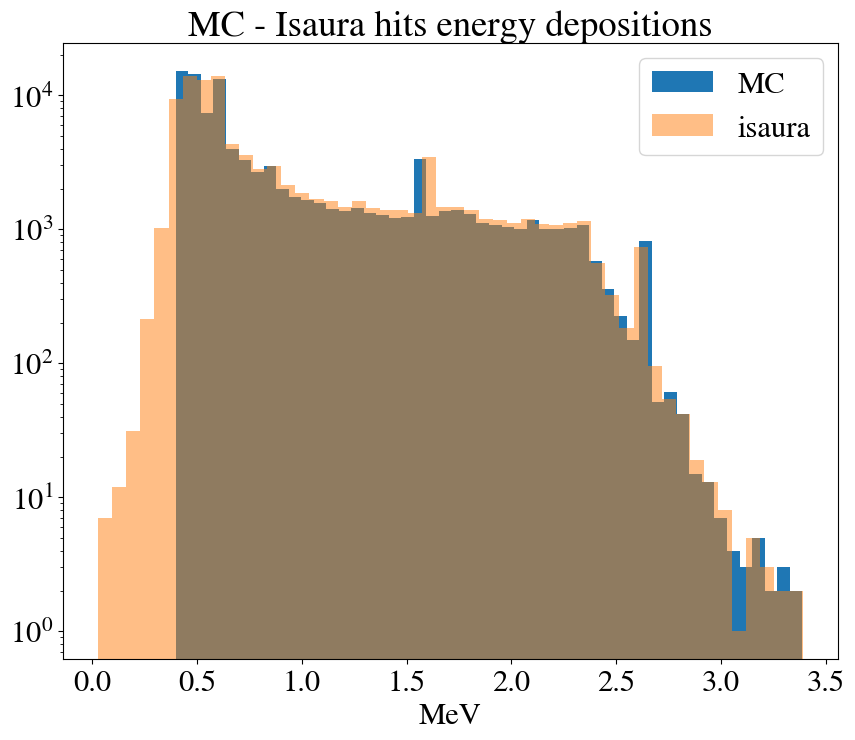

In [5]:
log_check= True
# plot energy of hits as histograms.
plt.hist(mc_E, bins = 50, log = log_check, label = 'MC')
plt.hist(event_E, bins = 50, log = log_check, alpha = 0.5, label = 'isaura')
plt.title("{}".format('MC - Isaura hits energy depositions'))
plt.legend()
plt.xlabel('MeV')
plt.show()


In [28]:
MC_signals = np.load('port_1a_signal_evts.npy')
lost_signals = np.load('port_1a_isaura_lost_evts.npy')/2
# just showing that there are odd values
print([x for x in MC_signals if x%2 != 0 ])
print(len([x for x in lost_signals if x in MC_signals ]))
print(len(lost_signals))

[2540033, 2540091, 2540097, 2540123, 2540135, 2540183, 2540187, 2540193, 2540229, 2540273, 2540291, 2540301, 2540311, 2540317, 2540343, 2540349, 870011, 870067, 870071, 870091, 870125, 870155, 870233, 870269, 1790085, 1790161, 1790177, 1790187, 1790209, 1790235, 1790245, 1790267, 1790273, 1790297, 1790299, 570013, 570057, 570071, 570075, 570081, 570085, 570089, 570105, 570129, 570145, 570167, 570175, 570305, 1630003, 1630011, 1630115, 1630151, 1630223, 1630249, 1630255, 1630267, 1630277, 1630293, 1630295, 40003, 40007, 40011, 40019, 40135, 40171, 40205, 40257, 40289, 40295, 40301, 40317, 10011, 10019, 10057, 10149, 10157, 10173, 10179, 10185, 10225, 10273, 10285, 10293, 1950013, 1950027, 1950055, 1950287, 1950323, 1950325, 1950337, 780023, 780077, 780093, 780129, 780147, 780221, 780277, 780303, 780321, 780327, 1920011, 1920037, 1920047, 1920081, 1920133, 1920219, 1920239, 1920271, 1360025, 1360039, 1360053, 1360063, 1360123, 1360141, 1360155, 1360289, 1360303, 1360339, 2900017, 2900029

In [8]:
# load data
folder_path = '../FOM_merge&fit/12_12_18/PORT_1a/isaura/'
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]


i = 0

print("Loading in DECO...")
event_E = []
event_MC = []
for file in tqdm(file_names):
    file_path = folder_path + file
    df = dstio.load_dst(file_path, 'DECO', 'Events')

    signal_df = df[df['event'].isin(MC_signals*2)]
    for event, df in signal_df.groupby("event"):
        event_E.append(df.E.sum())


    df = mcio.load_mchits_df(file_path).reset_index()
    signal_df = df[df['event_id'].isin(MC_signals)]
    for event, df in signal_df.groupby("event_id"):
        event_MC.append(df.energy.sum())

    #if (i == 0):
    #    isaura_hits_E = df.E.to_numpy()

    #    i +=1
    #else:
    #    isaura_hits_E = np.concatenate((df.E.to_numpy(), isaura_hits_E))


Loading in DECO...


100%|██████████| 300/300 [08:23<00:00,  1.68s/it]


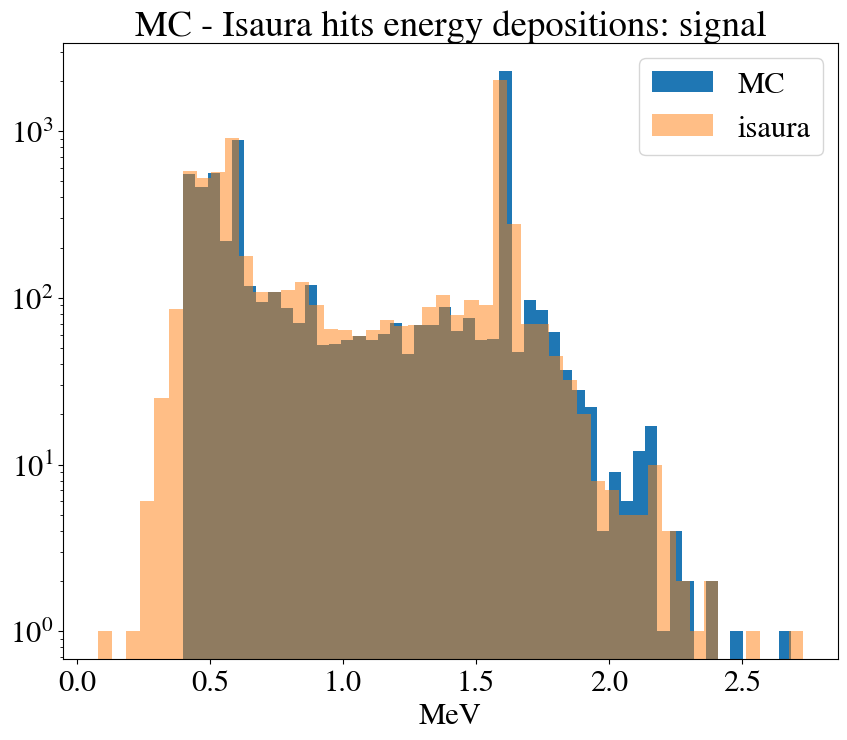

In [16]:
log_check= True
# plot energy of hits as histograms.
plt.hist(event_MC, bins = 50, log = log_check, label = 'MC')
plt.hist(event_E, bins = 50, log = log_check, alpha = 0.5, label = 'isaura')
plt.title("{}".format('MC - Isaura hits energy depositions: signal'))
plt.legend()
plt.xlabel('MeV')
plt.show()


In [29]:
print("Loading in DECO...")
event_E = []
event_MC = []
for file in tqdm(file_names):
    file_path = folder_path + file
    df = dstio.load_dst(file_path, 'DECO', 'Events')

    signal_df = df[df['event'].isin(lost_signals*2)]
    for event, df in signal_df.groupby("event"):
        event_E.append(df.E.sum())


    df = mcio.load_mchits_df(file_path).reset_index()
    signal_df = df[df['event_id'].isin(lost_signals)]
    for event, df in signal_df.groupby("event_id"):
        event_MC.append(df.energy.sum())

Loading in DECO...


100%|██████████| 300/300 [08:07<00:00,  1.63s/it]


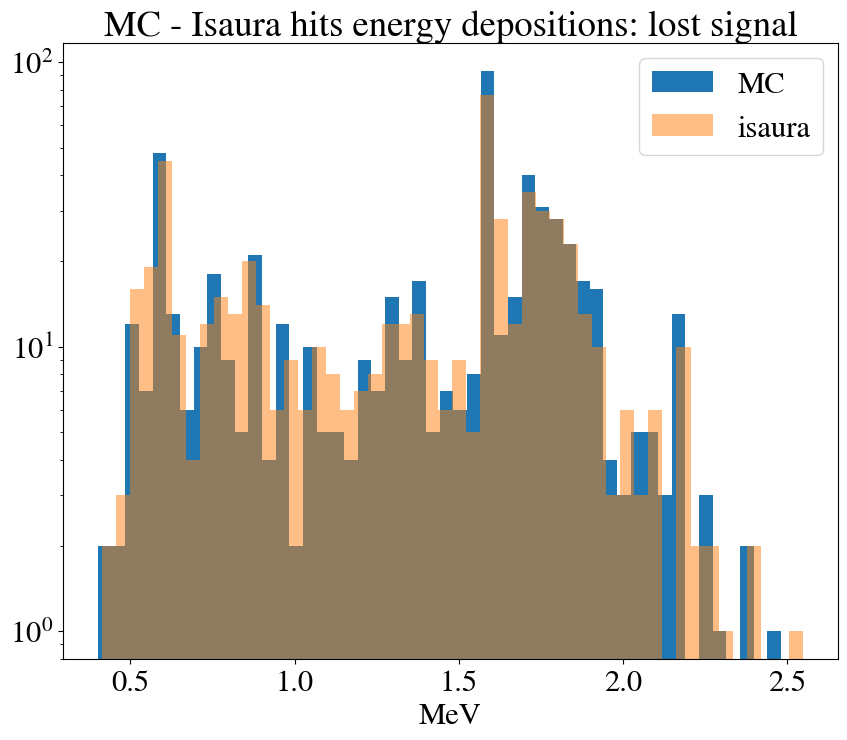

In [30]:
log_check= True
# plot energy of hits as histograms.
plt.hist(event_MC, bins = 50, log = log_check, label = 'MC')
plt.hist(event_E, bins = 50, log = log_check, alpha = 0.5, label = 'isaura')
plt.title("{}".format('MC - Isaura hits energy depositions: lost signal'))
plt.legend()
plt.xlabel('MeV')
plt.show()

In [20]:
low_E_MC = []
for file in tqdm(file_names):
    file_path = folder_path + file

    df = mcio.load_mchits_df(file_path).reset_index()
    signal_df = df[df['event_id'].isin(lost_signals)]

    for event, df in signal_df.groupby("event_id"):
        if (df.energy.sum() < 0.7):
            low_E_MC.append(event)
        


100%|██████████| 300/300 [00:31<00:00,  9.55it/s]


In [22]:
print([x for x in low_E_MC if x%2 != 0 ])

[]


In [ ]:
for file in tqdm(file_names):
    file_path = folder_path + file
    df_ps = pd.read_hdf(file_path, 'MC/particles')
    relevant_df = df_ps[df_ps['event_id'].isin(low_E_MC)]